In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using:', device)

using: cuda


In [22]:

HIDDEN_SIZE = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 150
BATCH_SIZE = 32
SEQ_LENGTH = 100

In [23]:
class CharLSTM(nn.Module):
    """
    Character level LSTM for text generation
    """


    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        # input: (batch,seq_len, input_size)
        # output: (batch,seq_len, hidden_size)

        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True)

        self.fc = nn.Linear(hidden_size, output_size)
        sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        """
        Forward pass through LSTM

        Args:
            x: Input tensor (batch, seq_len, input_size)
            hidden: Tuple of (h_0, c_0)
                h_0: Hidden state (num_layers, batch, hidden_size)
                c_0: Cell state (num_layers, batch, hidden_size)

        Returns:
            output: Predictions (batch * seq_len, output_size)
            hidden: Updated hidden state tuple (h_n, c_n)
        """
        # LSTM forward
        # out: (batch, seq_len, hidden_size)
        # hidden: (h_n,c_n), each (num_layers, batch, hidden_size)
        out, hidden = self.lstm(x,hidden)


        # out: (batch * seq_len, hidden_size)
        # Reshape for FC layer
        out = out.reshape(-1, self.hidden_size)

        # FC layer
        # out: (batch * seq_len, output_size)
        out = self.fc(out)

        return out, hidden

    def init_hidden(self,batch_size):
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device, non_blocking = True)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device, non_blocking = True)
        return (h_0,c_0)


In [24]:
class TextDataset(Dataset):

    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length

        # Char to index mapping
        self.chars = sorted(list(set(self.text)))
        self.char_idx = {ch:i for i,ch in enumerate(self.chars)}
        self.idx_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)

        print(f"Vocabulary size: {self.vocab_size}")
        print(f"Unique characters: {self.chars}")

    def __getitem__(self,idx):

        seq = self.text[idx:idx+self.seq_length]
        target = self.text[idx + 1: idx + self.seq_length + 1]

        seq_idx = torch.tensor([self.char_idx[ch] for ch in seq])
        target_idx = torch.tensor([self.char_idx[ch] for ch in target])

        return seq_idx, target_idx


    def __len__(self):
        return len(self.text) - self.seq_length

In [25]:
def generate_text(model, dataset, start_str="The ", length=500, device='cpu'):
    """
    Generate text using trained model

    Args:
        model: Trained LSTM model
        dataset: Dataset with char mappings
        start_str: String to start generation
        length: Number of characters to generate
        device: Device to run on

    Returns:
        generated_text: String of generated text
    """
    model.eval()

    chars = [ch for ch in start_str]
    hidden = model.init_hidden(1)

    with torch.no_grad():
        for i in range(length):
            # Get last seq_length characters (or all if less)
            input_chars = chars[-SEQ_LENGTH:] if len(chars) >= SEQ_LENGTH else chars

            # Pad if necessary
            while len(input_chars) < SEQ_LENGTH:
                input_chars = [' '] + input_chars

            # Convert to indices
            seq_idx = [dataset.char_idx.get(ch, 0) for ch in input_chars]
            seq_tensor = torch.tensor([seq_idx]).to(device)

            # One-hot encode
            seq_onehot = torch.nn.functional.one_hot(
                seq_tensor,
                num_classes=dataset.vocab_size
            ).float()

            # Predict next character
            output, hidden = model(seq_onehot, hidden)

            # Get prediction for last character
            prob = torch.nn.functional.softmax(output[-1], dim=0)

            # Sample from distribution (more interesting than argmax)
            next_char_idx = torch.multinomial(prob, 1).item()
            next_char = dataset.idx_char[next_char_idx]

            chars.append(next_char)

    return ''.join(chars)

In [26]:
# Load data
with open("input.txt", 'r', encoding = 'utf-8') as f:
    text = f.read()

In [27]:
# Create dataset
dataset = TextDataset( text, SEQ_LENGTH)
dataloader = DataLoader(
    dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True,
    num_workers = 2,
    pin_memory = True
)

Vocabulary size: 75
Unique characters: ['\t', '\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '[', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [28]:
# Model
model = CharLSTM(
    input_size = dataset.vocab_size,
    hidden_size = HIDDEN_SIZE,
    num_layers = NUM_LAYERS,
    output_size = dataset.vocab_size
).to(device)

In [29]:
print(f"\nModel architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Model architecture:
CharLSTM(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=75, bias=True)
)

Total parameters: 246,731


In [30]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    hidden = model.init_hidden(BATCH_SIZE)

    for batch_idx, (sequences, targets) in enumerate(dataloader):
        sequences = sequences.to(device, non_blocking = True)
        targets = targets.to(device, non_blocking = True)

        # one-hot encoding
        sequences_onehot = torch.nn.functional.one_hot(
            sequences,
            num_classes = dataset.vocab_size
        ).float()

        # forward pass
        #Detach hidden state to prevent backprop through entire history
        hidden = tuple([h.detach() for h in hidden])

        outputs, hidden = model(sequences_onehot, hidden)
        loss = criteria(outputs, targets.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {avg_loss:.4f}')

            # Generate sample
        sample = generate_text(
            model,
            dataset,
            start_str="The ",
            length=200,
            device=device
        )
        print(f'Sample: {sample}\n')



Epoch [10/150], Loss: 0.5765
Sample: The r leghacting in your peace of orcomfor hath bothers, and he will smile now
abe more than I have harve to commanno in fellow. Shice with anone wrack prounds abits. Sin
Toby and this oncert the regundly

Epoch [20/150], Loss: 0.4761
Sample: The raught is he?

TOBY  Excellent OLIVIA
What membraply of your hands,
and sake thee for a coward, but upon me, sir, that is my
do?--


MARIA  Awill nebit him too,
Turnur Andrew.

ANDREW  Marry, I saw yo

Epoch [30/150], Loss: 0.4428
Sample: The runch fore than the
gate a cowards. I have good ploy.
All it dely help in a sgulfend are I prit

MALVOLIO  "I may command where I adore
trate all tongur of you.

VIOLA
Thend hang her willis the meties

Epoch [40/150], Loss: 0.4241
Sample: The shall have shat you would what thou hast, betake thee bring but for
alewher. I would the brought your Ladychit I smine is
the you. He Saith, give money here in your igna-hou dissemblewal? Wimerow in t

Epoch [50/150], Loss: 0.4128

In [32]:
torch.save({
        'model_state_dict': model.state_dict(),
        'vocab_size': dataset.vocab_size,
        'char_to_idx': dataset.char_idx,
        'idx_to_char': dataset.idx_char,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS
    },'lstm_model.pth')

In [19]:
import matplotlib.pyplot as plt


Loss curve saved to results/lstm_loss.png


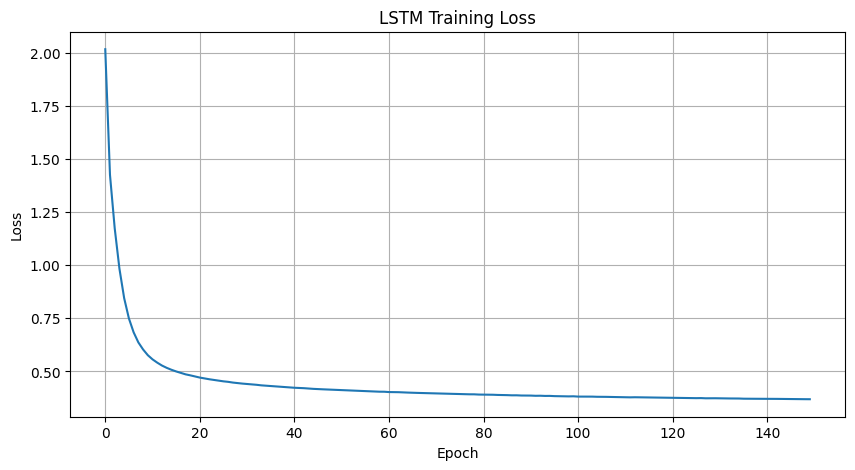

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss')
plt.grid(True)
plt.savefig('lstm_loss.png')
print("Loss curve saved to results/lstm_loss.png")

In [34]:
print("\n=== Text Generation Samples ===\n")
for start in ["The ", "In ", "When ", "She "]:
  sample = generate_text(
      model,
      dataset,
      start_str=start,
      length=400,
      device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  )
  print(f'Starting with "{start}":\n{sample}\n')
  print("-" * 80)


=== Text Generation Samples ===

Starting with "The ":
The Count' th' nay am at the opposite, thise comes to peace of the sport,
come from I will e the gre. This is opinianed the nother heal, not your seek rament of love of.
Let alone with
her. He is so quite of he?

MALVOLIO  "Be not afraid of greatness." 'Twas well
writ.
Jove, in I sun sing letter, my lord, what then?

ORSINO
O, then I have the gatter. But in nered rest fortune cast the me, and with thi

--------------------------------------------------------------------------------
Starting with "In ":
In has a m, that
is is he?

TOBY  He is knight, I am not see.

VIOLA  I thank thee. I am no first.

FABIAN  This is to give a dog and the sugab. Let me to befou ever s's, come the Count
Orsino's is heasterate at a say
him in many sorts of music. What means the world call thee better Fortund to death,
	   With hey, ho, to the Fobe minn leaving trup my maiden other as fin conth
SOLIVIA
Give me go, Lord

-------------------------------